In [2]:
import os

from keras.src.applications.resnet import ResNet50
from openpyxl.styles.builtins import output
from tensorboard.plugins.graph.keras_util import keras_model_to_graph_def
from webcolors import names

os.environ['KERAS_BACKEND'] = 'tensorflow'

from collections import defaultdict
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

2025-05-10 10:28:24.377131: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 10:28:24.658697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746869304.761196    2799 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746869304.786911    2799 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746869305.006864    2799 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [4]:
target_size = 32
representation_dims = 512
projection_unites = 128
num_clusters = 28
kn = 5
tune_encoder_during_clustering = False

In [5]:
data_processing = keras.Sequential([
    layers.Resizing(target_size, target_size),
    layers.Normalization()
])

data_processing.layers[-1].adapt(x_data)

I0000 00:00:1746869310.068066    2799 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(
        height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest'
    ),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.15, fill_mode='nearest'),
    layers.RandomZoom(
        height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode='nearest'
    ),
])

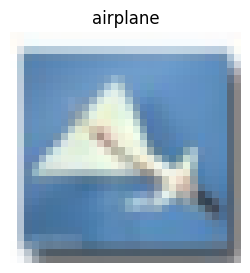

In [7]:
image_index = np.random.choice(range(x_data.shape[0]))
image = x_data[image_index]
image_class = classes[y_data[image_index][0]]
plt.figure(figsize=(3,3))
plt.imshow(x_data[image_index].astype('uint8'))
plt.title(image_class)
_ = plt.axis('off')

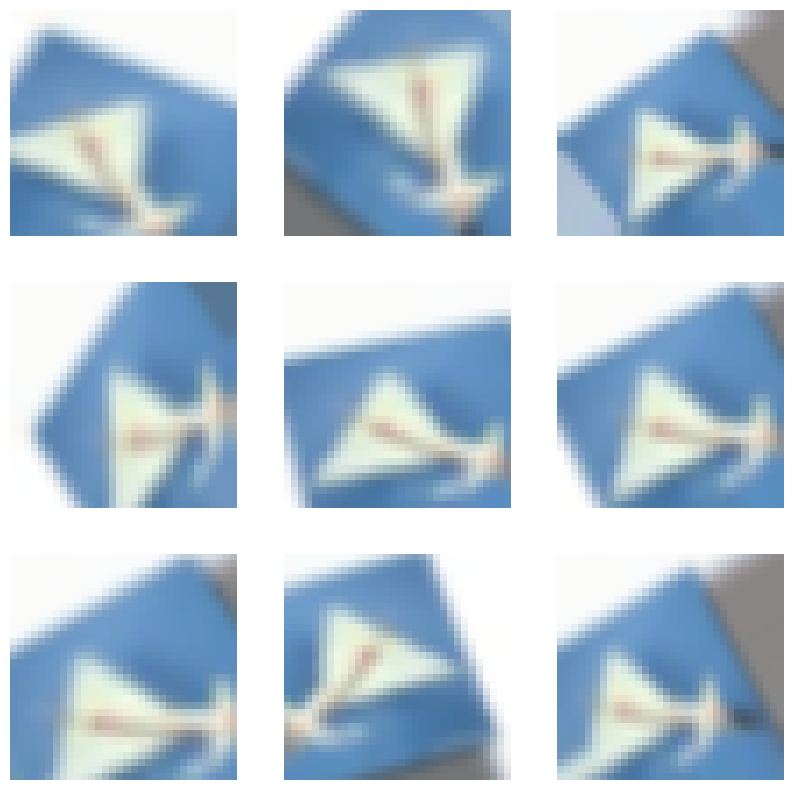

In [8]:
plt.figure(figsize=(10,10))

for i in range(9):
    augmented_image = data_augmentation(np.array([image]))
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

In [9]:
def create_encoder(representation_dims):
    encoder = ResNet50(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(32, 32, 3),
    )
    return encoder

In [10]:
class RepresentationLearner(keras.Model):
    def __init__(self, encoder, projection_unites, num_augmentations, temperature=1.0, dropout_rate=0.1, i2_normalize=True, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder

        self.projector = keras.Sequential([
            layers.Dropout(dropout_rate),
            layers.Dense(units=projection_unites, use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.i2_normalize = i2_normalize
        self.loss_tracker = keras.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vector, batch_size):
        num_augmentations = keras.ops.shape(feature_vector)[0] // batch_size
        if self.i2_normalize:
            feature_vector = keras.utils.normalize(feature_vector)

        logits = (
            tf.linalg.matmul(feature_vector, feature_vector, transpose_b=True) / self.temperature
        )

        logits_max = keras.ops.max(logits, axis=1)
        logits = logits - logits_max

        targets = keras.ops.tile(
            tf.eye(batch_size), [num_augmentations, num_augmentations],
        )

        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        preprocessed = data_processing(inputs)
        augmented = []

        for _ in range(self.num_augmentations):
            augmented_img = data_augmentation(preprocessed)
            augmented.append(self.encoder(augmented_img))

        features = layers.Concatenate(axis=0)(augmented)
        return self.projector(features)


    def train_step(self, inputs):
        batch_size = keras.ops.shape(inputs)[0]

        with tf.GradientTape() as tape:
            features_vector = self(inputs, training=True)
            loss = self.compute_contrastive_loss(features_vector, batch_size)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = keras.ops.shape(inputs)[0]
        features_vector = self(inputs, training=False)
        loss = self.compute_contrastive_loss(features_vector, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [12]:
encoder = create_encoder(representation_dims)
batch_size = 500
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
feature_vectors = keras.utils.normalize(feature_vectors)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


I0000 00:00:1746869363.886715    2979 service.cc:152] XLA service 0x563c4811ea60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746869363.886740    2979 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-10 10:29:23.935515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746869364.240817    2979 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

I0000 00:00:1746869366.494887    2979 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


In [13]:
feature_vectors

array([[0.03550029, 0.00941902, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00266611, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00884691, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03356332, 0.00814672, 0.        , ..., 0.02621412, 0.        ,
        0.        ],
       [0.        , 0.00118942, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00208535, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [14]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = keras.ops.top_k(similarities, k=kn + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, kn))

100%|██████████| 120/120 [00:16<00:00,  7.23it/s]


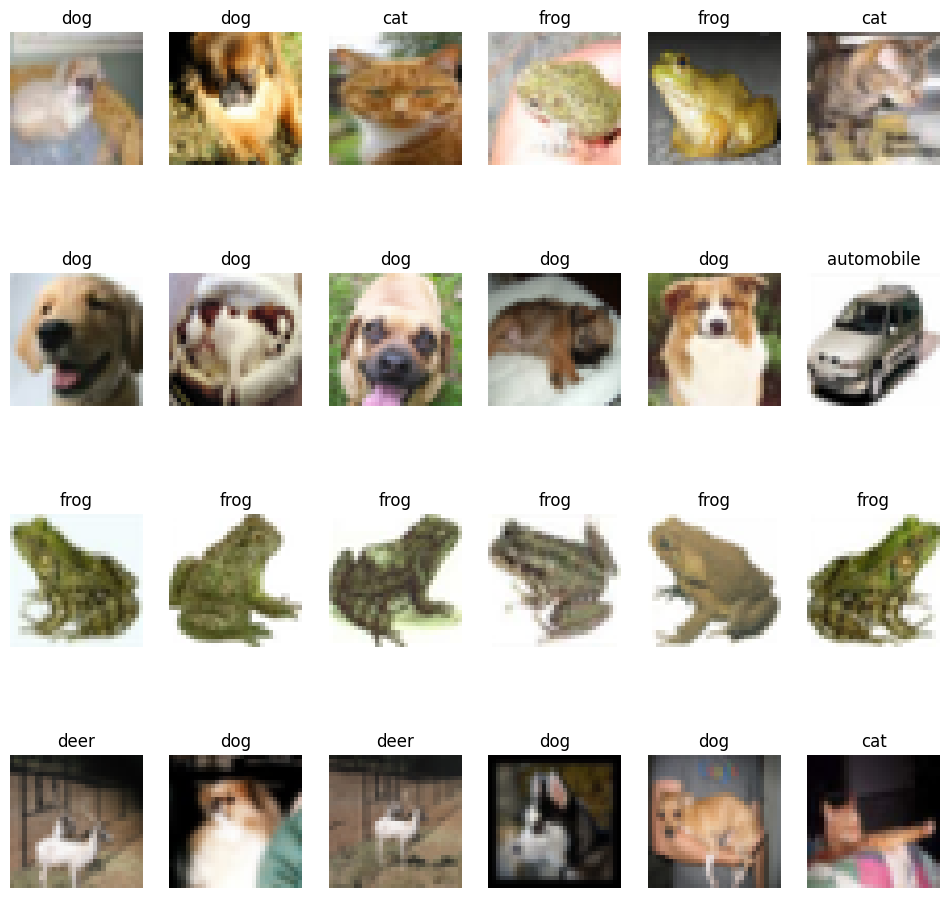

In [15]:
nrows = 4
ncols = kn + 1

plt.figure(figsize=(12, 12))
positions = 1

for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indices = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indices.tolist()

    for j in range(ncols):
        plt.subplot(nrows, ncols, positions)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        plt.title(classes[y_data[indices[j]][0]])
        plt.axis('off')
        positions += 1



In [16]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        target = keras.ops.ones_like(similarity)

        loss = keras.losses.binary_crossentropy(
            y_true=target,
            y_pred=similarity,
            from_logits=True
        )

        return keras.ops.mean(loss)

In [17]:
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probablities, similarity, sample_weight=None):
        num_clusters = keras.ops.cast(
            keras.ops.shape(cluster_probablities)[-1], 'float32'
        )

        target = keras.ops.log(num_clusters)
        cluster_probablities = keras.ops.mean(cluster_probablities, axis=0)
        cluster_probablities = keras.ops.clip(cluster_probablities, 1e-8, 1.0)

        entropy = -keras.ops.sum(
            cluster_probablities * keras.ops.log(cluster_probablities),
        )
        loss = target - entropy

        return loss

In [18]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    preprocessed = data_processing(inputs)
    augmented = data_augmentation(preprocessed)
    features = encoder(augmented)
    outputs = layers.Dense(units=num_clusters, activation='softmax')(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [19]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name='anchor')
    neighbours = keras.Input(shape=tuple([kn]) + input_shape, name='neighbours')

    neighbours_reshaped = keras.ops.reshape(neighbours, tuple([-1]) + input_shape)

    anchor_clustering = clustering_model(anchor)
    neighbour_clustering = clustering_model(neighbours_reshaped)
    neighbour_clustering = keras.ops.reshape(
        neighbour_clustering,
        (-1, kn, keras.ops.shape(neighbour_clustering)[-1])
    )

    simlarity = keras.ops.einsum(
        "bij,bkj->bik",
        keras.ops.expand_dims(anchor_clustering, axis=1),
        neighbour_clustering,
    )

    simlarity = layers.Lambda(
        lambda x: keras.ops.squeeze(x, axis=1), name='simlarity'
    ) (simlarity)

    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[simlarity, anchor_clustering],
        name='clustering_learner'
    )

    return model

In [22]:
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering

clustering_model = create_clustering_model(encoder, num_clusters, name='clustering')
clustering_learner = create_clustering_learner(clustering_model)

losses = [ClustersEntropyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]

inputs = {"anchor": x_data, 'neighbours': tf.gather(x_data, neighbours)}
labels = [np.ones(shape=(x_data.shape[0], kn)), np.ones(shape=(x_data.shape[0], kn))]

clustering_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
    jit_compile=False,
)

history = clustering_learner.fit(
    x=inputs,
    y=labels,
    batch_size=512,
    epochs=50
)


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - clustering_loss: 0.6147 - loss: 0.7088 - simlarity_loss: 0.0941
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - clustering_loss: 0.5014 - loss: 0.5099 - simlarity_loss: 0.0085
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - clustering_loss: 0.4515 - loss: 0.4747 - simlarity_loss: 0.0232
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - clustering_loss: 0.4415 - loss: 0.4559 - simlarity_loss: 0.0144
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - clustering_loss: 0.4213 - loss: 0.4409 - simlarity_loss: 0.0196
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - clustering_loss: 0.4085 - loss: 0.4312 - simlarity_loss: 0.0227
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - clustering_loss: 0.3969 - loss: 0.4194 - simlarity_loss: 0.0226
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - clustering_loss: 0.3849 - loss: 0.4169 - simlarity_loss: 0.0320
Epoch 9/50
118/118 ━━━━━━━━━━━━━

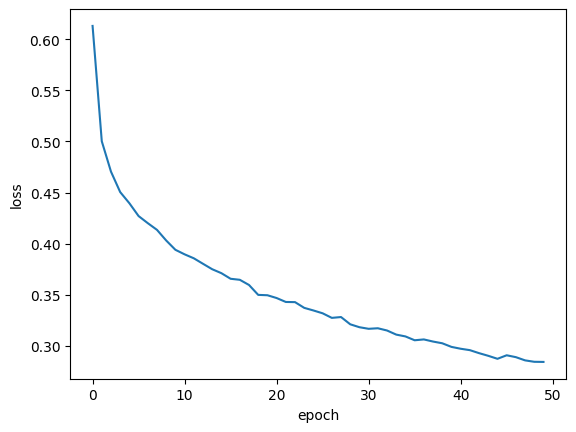

In [23]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [24]:
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)
clustering_assigments = keras.ops.argmax(clustering_probs, axis=-1).numpy()

clustering_confidence = keras.ops.max(clustering_probs, axis=-1).numpy()

120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


In [25]:
import pandas as pd
pd.DataFrame(clustering_assigments)

,0
0,3
1,16
2,16
3,22
4,19
...,...
59995,3
59996,26
59997,3
59998,16


In [26]:
pd.DataFrame(clustering_confidence)

,0
0,0.999517
1,0.638365
2,0.999985
3,0.849910
4,0.640953
...,...
59995,0.783782
59996,0.315838
59997,0.999940
59998,0.441182


In [27]:
clusters = defaultdict(list)
for idx, c in enumerate(clustering_assigments):
    clusters[c].append((idx, clustering_confidence[idx]))

non_empty_clusters = defaultdict(list)

for c in clusters.keys():
    if clusters[c]:
        non_empty_clusters[c] = clusters[c]

for c in range(num_clusters):
    print('cluster',c,':', len(clusters[c]))


cluster 0 : 559
cluster 1 : 979
cluster 2 : 1357
cluster 3 : 9201
cluster 4 : 264
cluster 5 : 1751
cluster 6 : 2264
cluster 7 : 200
cluster 8 : 521
cluster 9 : 428
cluster 10 : 3258
cluster 11 : 1065
cluster 12 : 1549
cluster 13 : 1360
cluster 14 : 262
cluster 15 : 1456
cluster 16 : 16348
cluster 17 : 1952
cluster 18 : 1441
cluster 19 : 1462
cluster 20 : 600
cluster 21 : 1864
cluster 22 : 2127
cluster 23 : 423
cluster 24 : 2428
cluster 25 : 656
cluster 26 : 822
cluster 27 : 3403


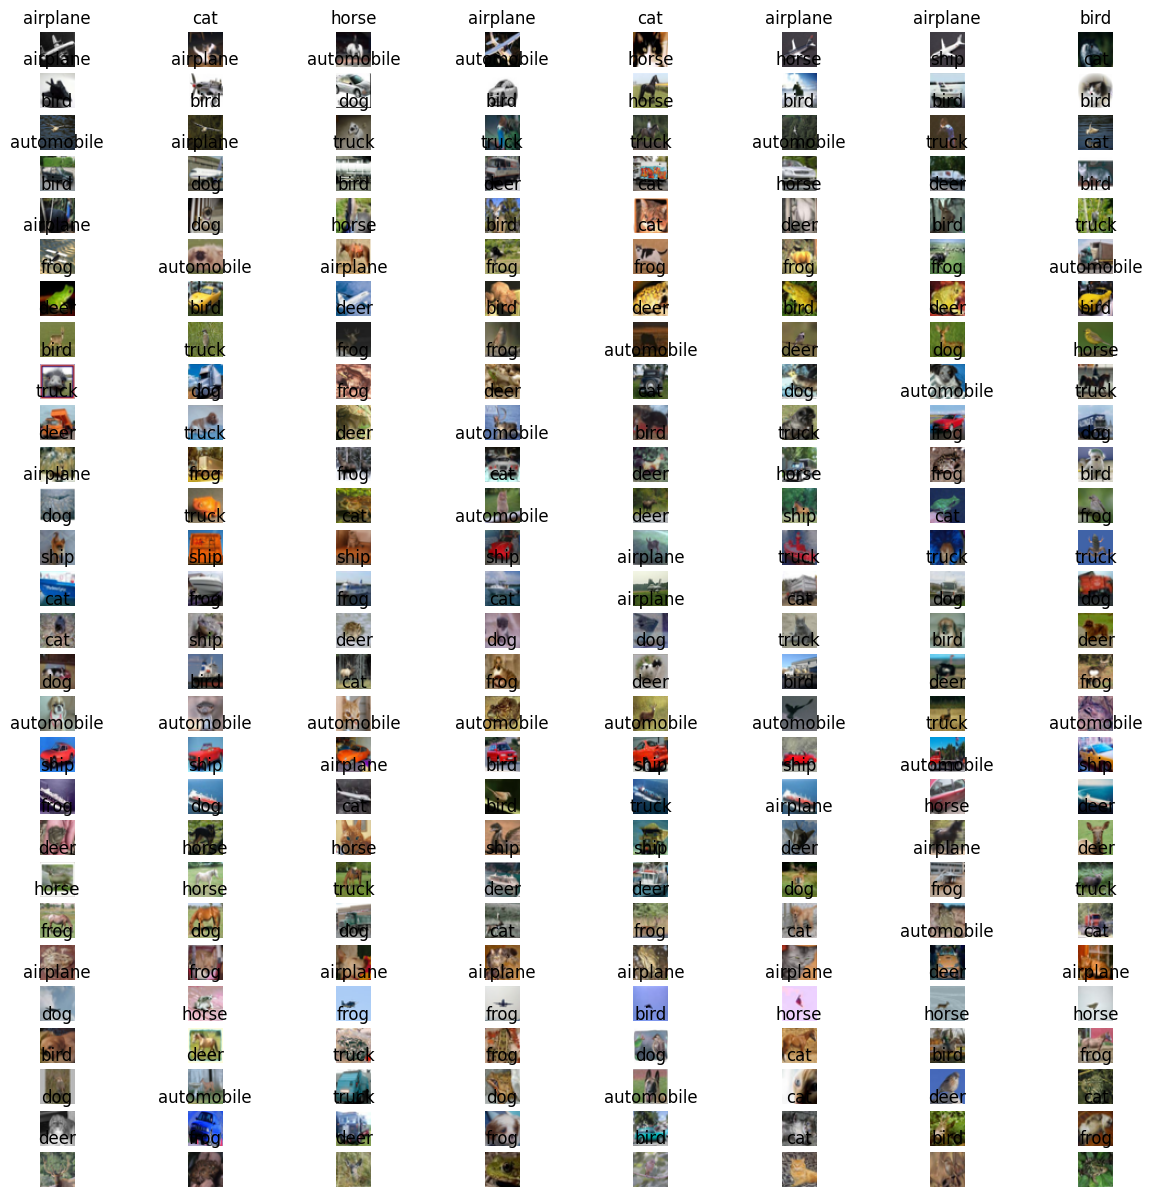

In [28]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1
for c in non_empty_clusters.keys():
    cluster_instances = sorted(
        non_empty_clusters[c], key=lambda kv: kv[1], reverse=True
    )

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(len(non_empty_clusters), num_images, position)
        plt.imshow(x_data[image_idx].astype("uint8"))
        plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1




In [29]:
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]


    for i, _ in instances:
        cluster_label_counts[c][y_data[i][0]] += 1


    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])

    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )

    cluster_label = classes[cluster_label_idx]

    print('cluster ', c, 'label is: ', cluster_label, ' - accuracy: ', accuracy, '%')

cluster  0 label is:  deer  - accuracy:  22.54 %
cluster  1 label is:  deer  - accuracy:  30.85 %
cluster  2 label is:  bird  - accuracy:  21.37 %
cluster  3 label is:  dog  - accuracy:  21.04 %
cluster  4 label is:  ship  - accuracy:  22.73 %
cluster  5 label is:  deer  - accuracy:  13.99 %
cluster  6 label is:  frog  - accuracy:  15.46 %
cluster  7 label is:  cat  - accuracy:  21.5 %
cluster  8 label is:  dog  - accuracy:  23.22 %
cluster  9 label is:  deer  - accuracy:  30.61 %
cluster  10 label is:  automobile  - accuracy:  19.18 %
cluster  11 label is:  truck  - accuracy:  30.61 %
cluster  12 label is:  deer  - accuracy:  43.12 %
cluster  13 label is:  deer  - accuracy:  15.37 %
cluster  14 label is:  bird  - accuracy:  23.28 %
cluster  15 label is:  ship  - accuracy:  42.24 %
cluster  16 label is:  truck  - accuracy:  16.32 %
cluster  17 label is:  frog  - accuracy:  20.85 %
cluster  18 label is:  ship  - accuracy:  24.29 %
cluster  19 label is:  automobile  - accuracy:  36.25 %
